<a href="https://colab.research.google.com/github/keripikkaneboo/Machine-Learning/blob/main/06.%20Week%206/OnlineRetail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown --id 1LeCr2Gx87AnIAVXeteMHxkzWtt2CWazD

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1LeCr2Gx87AnIAVXeteMHxkzWtt2CWazD
To: /content/Online Retail.xlsx
100% 23.7M/23.7M [00:00<00:00, 66.1MB/s]


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import pdist, squareform

In [6]:
# === Load dataset ===
df = pd.read_excel("/content/Online Retail.xlsx")

In [7]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [8]:
# === Preprocessing ===
df.dropna(subset=["CustomerID"], inplace=True)
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

In [9]:
# Aggregasi fitur per CustomerID
customer_df = df.groupby("CustomerID").agg({
    "InvoiceNo": "nunique",
    "Quantity": "sum",
    "TotalPrice": ["sum", "mean"]
}).reset_index()

In [10]:
# Rename kolom
customer_df.columns = ["CustomerID", "NumTransactions", "TotalQuantity", "TotalSpent", "AvgSpent"]

# Hapus CustomerID (hanya digunakan sebagai index, bukan fitur)
X = customer_df.drop("CustomerID", axis=1)

In [11]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [12]:
# === Normalisasi ===
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

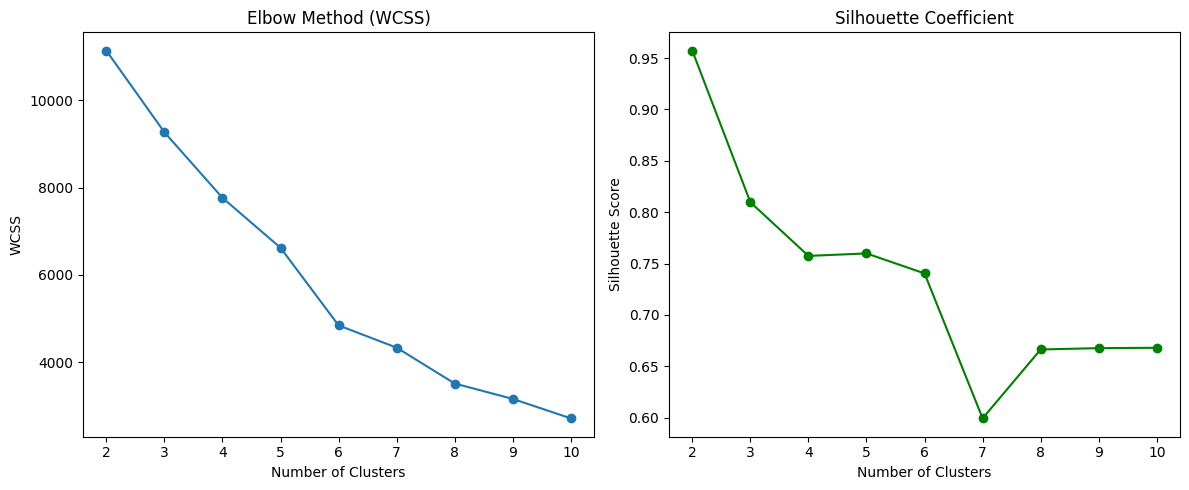

In [13]:
# === Elbow Method & Silhouette ===
wcss = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot Elbow & Silhouette
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, wcss, marker='o')
plt.title('Elbow Method (WCSS)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Coefficient')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

In [14]:
# Gunakan jumlah cluster terbaik berdasarkan Elbow/Silhouette
optimal_k = 4  # Ganti jika hasil Elbow/Silhouette menunjukkan angka lain

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# Calinski-Harabasz Index
ch_score = calinski_harabasz_score(X_scaled, labels)

# Davies-Bouldin Index (semakin kecil semakin baik)
db_score = davies_bouldin_score(X_scaled, labels)

# Dunn Index (semakin besar semakin baik)
def dunn_index(X, labels):
    distances = squareform(pdist(X))
    unique_clusters = np.unique(labels)

    intra_dists = [np.max(distances[np.ix_(labels == k, labels == k)]) for k in unique_clusters]
    inter_dists = [np.min(distances[np.ix_(labels == i, labels == j)])
                   for i in unique_clusters for j in unique_clusters if i != j]

    return np.min(inter_dists) / np.max(intra_dists)

dunn = dunn_index(X_scaled, labels)

print("Evaluasi Clustering:")
print(f"Silhouette Score       : {silhouette_score(X_scaled, labels):.4f}")
print(f"Calinski-Harabasz Index: {ch_score:.2f}")
print(f"Davies-Bouldin Index   : {db_score:.4f}")
print(f"Dunn Index             : {dunn:.4f}")

Evaluasi Clustering:
Silhouette Score       : 0.7574
Calinski-Harabasz Index: 1822.08
Davies-Bouldin Index   : 0.9103
Dunn Index             : 0.0019


###  **Hasil Evaluasi untuk `k = 4`**

| Metrik                      | Nilai   | Interpretasi                                                          |
| --------------------------- | ------- | --------------------------------------------------------------------- |
| **Silhouette Score**        | 0.7574  | Sangat baik → cluster cukup terpisah dan kompak                       |
| **Calinski-Harabasz Index** | 1822.08 | Sangat tinggi → cluster terpisah jelas dengan variasi internal rendah |
| **Davies-Bouldin Index**    | 0.9103  | Relatif bagus → mendekati 0 (ideal), artinya cluster cukup berbeda    |
| **Dunn Index**              | 0.0019  | Sangat kecil → cluster terlalu berdekatan dibanding variasi internal  |

---

### **Kesimpulan:**

> **Silhouette Score** dan **Calinski-Harabasz Index** adalah **metrik terbaik** dalam evaluasi ini, karena:

* Nilainya **tinggi**
* Konsisten menunjukkan struktur cluster yang **jelas**
* Kurang dipengaruhi oleh outlier dibanding Dunn Index

## 1.  **Silhouette Score**

### **Rumus:**

$$
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
$$

* $a(i)$: rata-rata jarak antar titik $i$ ke **titik lain dalam klusternya sendiri** (kompaksi).
* $b(i)$: rata-rata jarak antar titik $i$ ke **titik dalam kluster terdekat lain** (pemisahan).
* $s(i) \in [-1, 1]$

### **Interpretasi:**

* $s(i)$ mendekati **1** → titik sangat cocok dengan klusternya.
* $s(i)$ mendekati **0** → titik berada di batas dua kluster.
* $s(i)$ negatif → titik mungkin salah kluster.

---

## 2.  **Calinski-Harabasz Index (CH Index)**

### **Rumus:**

$$
CH = \frac{\text{Tr}(B_k)}{\text{Tr}(W_k)} \cdot \frac{n - k}{k - 1}
$$

* $\text{Tr}(B_k)$: jumlah variansi **antar cluster** (between-cluster dispersion)
* $\text{Tr}(W_k)$: jumlah variansi **dalam cluster** (within-cluster dispersion)
* $n$: jumlah total data
* $k$: jumlah cluster

### **Interpretasi:**

* Semakin **besar CH**, semakin **baik clustering** (cluster jauh satu sama lain dan padat di dalam).

---

## 3.  **Davies-Bouldin Index**

### **Rumus:**

$$
DB = \frac{1}{k} \sum_{i=1}^{k} \max_{j \ne i} \left( \frac{S_i + S_j}{M_{ij}} \right)
$$

* $S_i$: rata-rata jarak tiap titik ke centroid kluster $i$
* $M_{ij}$: jarak antara centroid kluster $i$ dan $j$

### **Interpretasi:**

* Semakin **rendah nilai DB**, semakin **baik** (cluster kompak dan jauh dari satu sama lain).

---

## 4.  **Dunn Index**

### **Rumus:**

$$
D = \frac{\min_{1 \leq i < j \leq k} d(c_i, c_j)}{\max_{1 \leq l \leq k} \delta_l}
$$

* $d(c_i, c_j)$: jarak minimum antar dua **cluster berbeda**
* $\delta_l$: diameter (maksimal jarak antar titik dalam) cluster $l$

### **Interpretasi:**

* Semakin **tinggi** Dunn Index, semakin **baik** clustering.
* Mengukur **rasio pemisahan antar cluster** dibanding **penyebaran internal cluster**.